## Import Libraries Packages, Downloads

In [65]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import math as mt


warnings.filterwarnings('ignore')

## Loading and Processing Data
`Note: (Because none of the processing we are doing involves imputation or such, we are doing the processing before the split)`

In [35]:
#warnings.filterwarnings('ignore')
Data = pd.read_csv('formatted_data.csv')

## Plotting

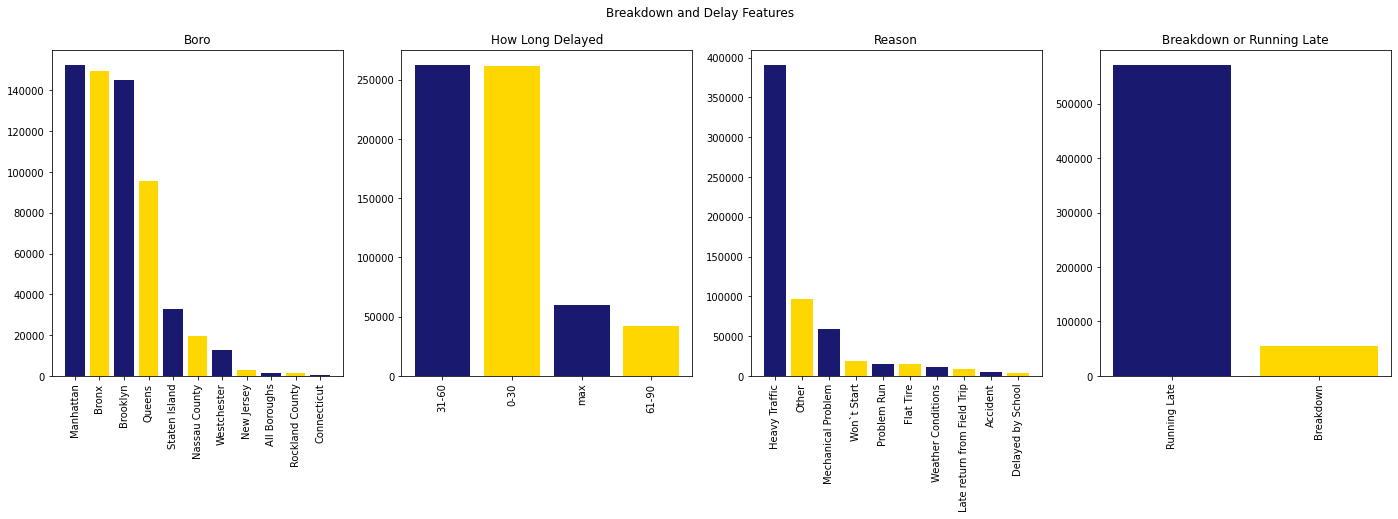

In [47]:
#warnings.filterwarnings('ignore')

columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Breakdown and Delay Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

colors = ['midnightblue', 'gold']
i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values, color = colors)
    axs[i].set_title(f"{column_name.replace('_', ' ')}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1

plt.savefig('breakdown_figures.pdf', bbox_inches = "tight")



In [48]:
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 6))
    fig.suptitle("Time Series Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()
    colors = ['midnightblue', 'gold']

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values, color = colors)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    plt.savefig('Time_features.pdf', bbox_inches = "tight")

    return data


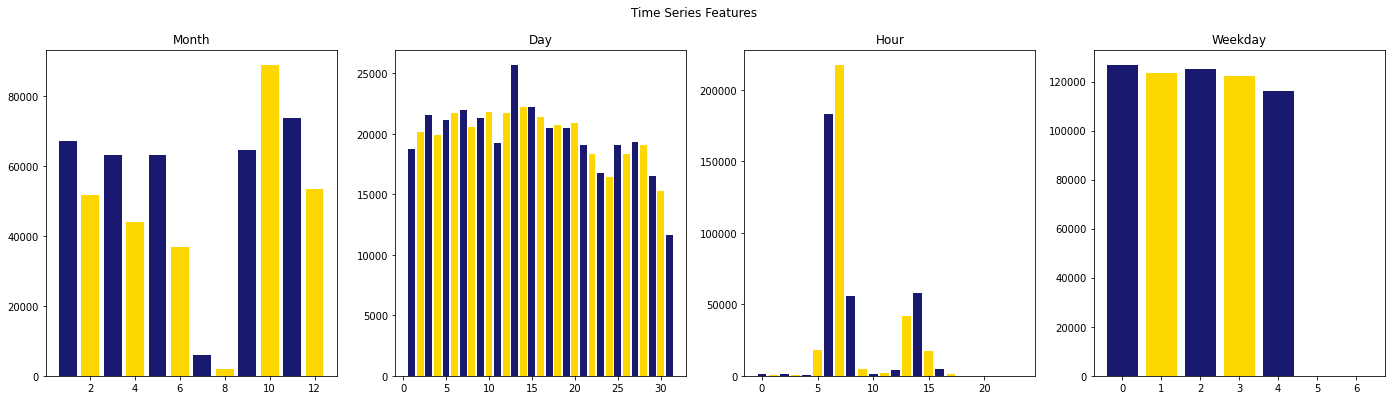

In [49]:
#Process the data
df = process(Data)


### Train Test Split

In [72]:
from itertools import combinations

pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))

classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'max'}
inverse_classes = {'0-30':0, '31-60':1, '61-90':2, '91-120':3, 'max':4}

#this method takes all the pairwise choices of the labels and returns the classes
def pairwise_sets(df, pair_list):
    #getting the pairwise rows of the data frame

    pairings = {}
    sum = 0

    for pair in pair_list:

        all_rows_with_labels = df.loc[(df['How_Long_Delayed'].isin(pair))]

        y = all_rows_with_labels['How_Long_Delayed']
        X = all_rows_with_labels.drop(['How_Long_Delayed'], axis = 1)

        pairings[pair] = [X,y] 
    return(pairings)

In [40]:
# split data into training and testing data at a .9 ratio
training_data = df.sample(frac = .9)
testing_data = df.drop(training_data.index)

training_paired = pairwise_sets(training_data, pairs) 
testing_paired= pairwise_sets(testing_data, pairs)


# Machine Learning



In [41]:
#ML libraries
#warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

1) ## Baseline Logistic Regression 

In [73]:
## Baseline Logistic Regression 
models_baseline = {}

for pair in pairs:

    (X_train, y_train) = training_paired[pair]


    to_binary = {pair[0]:0, pair[1]:1}
    y_train = y_train.map(to_binary)
    
    
    pipe = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree = 1)),
            ('pca', PCA(n_components=3)),
            ('mod', LogisticRegression())

        ])

    grid_cv = GridSearchCV(pipe, 
                        param_grid=
        {
            'mod': [ LogisticRegression()],
            'scaler': [StandardScaler()],
            'poly__degree': [1],

        },
        verbose = 1,
        cv = 2,
        return_train_score= True
    )
    
    grid_cv.fit(X_train, y_train)

    best_estimator = grid_cv.best_estimator_

    models_baseline[pair] = best_estimator

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


## Building The Random Forrest Classifiers



In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [43]:
models = {}

for pair in pairs:

    (X_train, y_train) = training_paired[pair]


    to_binary = {pair[0]:0, pair[1]:1}
    y_train = y_train.map(to_binary)


    best_params = {
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 200}

    model = RandomForestClassifier(**best_params)
    model.fit(X_train, y_train)

    models[pair] = model






## Evaluation

In [62]:
# Libraries
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import statistics as stat
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

#### Making ROC and Precision Recall Curves

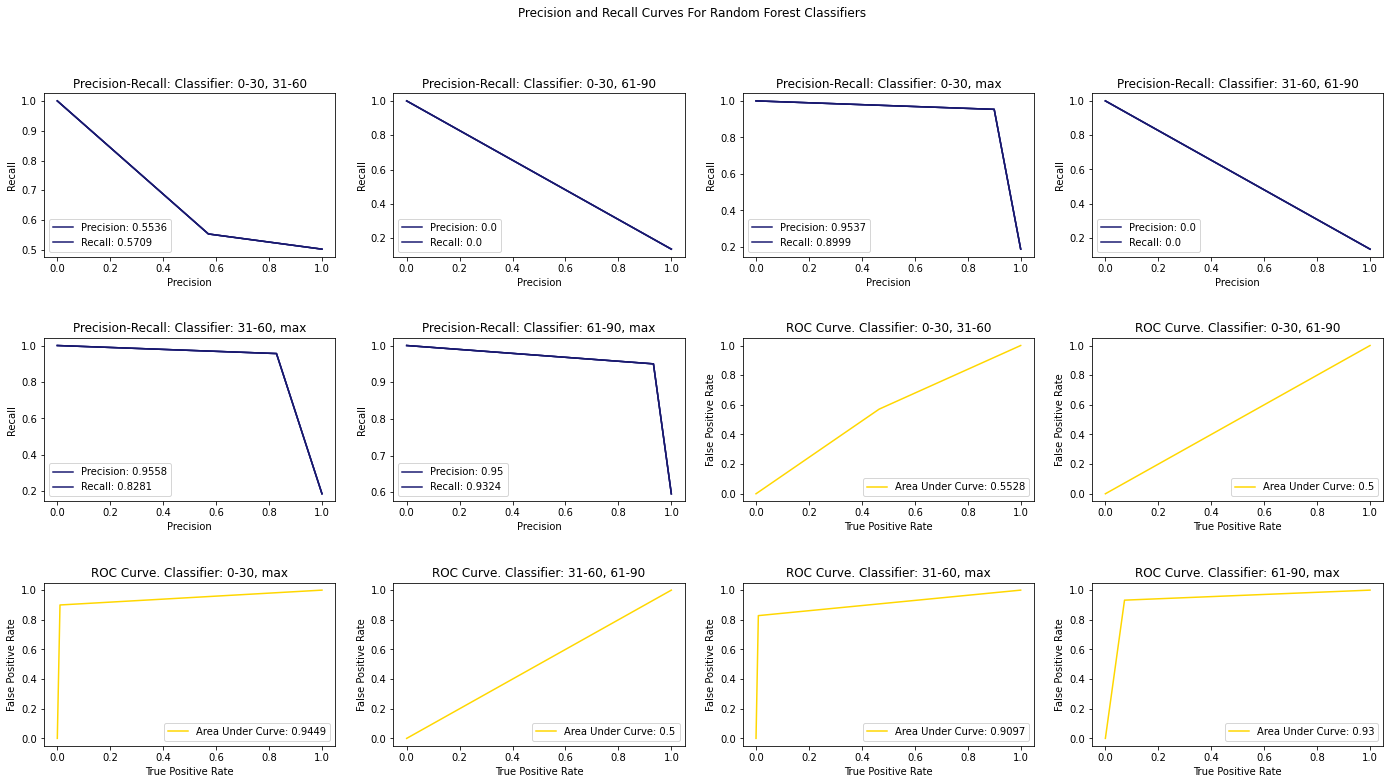

In [76]:

fig, axs = plt.subplots(3,4, figsize=(24, 12))

fig.suptitle("Precision and Recall Curves For Random Forest Classifiers")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
colors = ['midnightblue', 'gold']


i = 0
for pair in pairs:
    
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict(X_test)

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    prec_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    precision, recall, threshholds = precision_recall_curve(y_test, y_pred)


    axs[i].plot(recall, precision, color = 'midnightblue', label = f"Precision: {prec_score.round(4)}")
    axs[i].plot(recall, precision, color = 'midnightblue', label = f"Recall: {rec_score.round(4)}")
    axs[i].plot(recall, precision, color = 'midnightblue')
    axs[i].set_title(f"Precision-Recall: Classifier: {pair[0]}, {pair[1]}")
    axs[i].set_ylabel('Recall')
    axs[i].set_xlabel('Precision')
    axs[i].legend(loc = 'lower left')
    i += 1


i = 6

for pair in pairs:
    
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict(X_test)

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    axs[i].plot(fpr, tpr,  color = 'gold', label = f"Area Under Curve: {auc.round(4)}")
    axs[i].set_title(f"ROC Curve. Classifier: {pair[0]}, {pair[1]}")
    axs[i].set_ylabel('False Positive Rate')
    axs[i].set_xlabel('True Positive Rate')
    axs[i].legend(loc = 'lower right')
    axs
    i += 1

plt.savefig('ROC_Curves.pdf', bbox_inches = "tight")
plt.show()


### Individual Estimator and Micro-Averaged Scores

In [79]:
## Metrics # Macro

pairs = list(combinations(np.unique(df['How_Long_Delayed']),2))


f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

scores = pd.DataFrame()

from sklearn.metrics import RocCurveDisplay

for pair in pairs:
    
    classifier = models[pair]

    (X_test, y_test) = testing_paired[pair]
    y_pred = classifier.predict(X_test)

    to_binary = {pair[0]:0, pair[1]:1}
    y_test = y_test.map(to_binary)

    auc_scores.append(roc_auc_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

#average scores
micro_accuracy = stat.mean(accuracy_scores)
micro_precision = stat.mean(precision_scores)
micro_recall = stat.mean(recall_scores)
micro_f1 = stat.mean(f1_scores)
micro_auc = stat.mean(auc_scores)

pairs.append('micro averaged scores')

accuracy_scores.append(micro_accuracy)
precision_scores.append(micro_precision)
recall_scores.append(micro_recall)
f1_scores.append(micro_f1)
auc_scores.append(micro_auc)


scores['Classifier Pair'] = pairs
scores['Accuracy'] = accuracy_scores
scores['Recall'] = recall_scores
scores['Precision'] = precision_scores
scores['F1'] = f1_scores
scores['AUC'] = auc_scores

scores.round(4).to_csv('individual_class_metrics_baseline.csv', index=False)


